In [1]:
# Database
import sqlite3

# Machine learning
import torch
from torch import nn
import numpy as np
from sklearn.model_selection import train_test_split

# NLP
import spacy

# Plots
import matplotlib.pyplot as plt

# Own fns
import preprocessing
import model_utils as model_utils


# 0. Fetch data from db

In [2]:
con = sqlite3.connect("../../db/db_training.sqlite")

cur = con.cursor()

In [3]:
# TODO: Use sqlutils.get_sql_statement()
with open("../../db/sql/select_all_text.sql") as sql_file:
    sql = sql_file.read()
    sql_file.close()

cur.execute(sql)

'''
Response format: list[(text, category)]
'''
response = cur.fetchall()

In [4]:
data_dict = {}
'''
Format: {[category]: list[page_text_content]}
'''

for page in response:
    text = page[0]
    category = page[1]

    if category not in list(data_dict.keys()):
        data_dict[category] = [text]
    else :
        data_dict[category].append(text)

print(len(data_dict["0"]))

22


# 1. Cleaning

In [5]:
cleaned_data_dict = {}
nlp = spacy.load("fr_core_news_lg")

for category in list(data_dict.keys()):
    cleaned_data_dict[category] = []

for category in list(data_dict.keys()):
    for text_content in data_dict[category]:
        cleaned_text = preprocessing.full_cleaning(text_content, nlp)

        cleaned_data_dict[category].append(cleaned_text)

print(cleaned_data_dict)

{'2': ['hitachi inspirer the next smart tv être ref hk hdr cm tcl tcl smart tv ref tcl dolby hdr atmos cm google tv integre lg lg cut smart tv être ref ur ic processeur avoir al gen hdr cm airplay dl integre adams paiement frais notre prix eco taxe inclure', 'lg lg good systeme audio high power cm de hauteur bluetooth boomer eclairage multicolore fonction dj et karaoke lg enceinte mobile lg eco participation inclure profiter de bas ultra puissant pour votre soiree de surpuissant double bass boost le haut parleur de bas lumineux shiny et dautre fonctionnalite apporter un rythme puissant pour un soiree memorabl votre smartphone se mettre au rythme de le musique illuminer le fete vous pouvoir connecter jusqua trois smartphone en mem temps et le tenir en air ou en placer un dans le socle pour voir le flash au rythme de le musique ea conforamer an de garantie sur electromenager joon super grave', 'smart tv road ex le smart tv oo led full hd cm smart tv wifi netflix eco part full hd hdmi th 

# 2. Create a vocabulary

In [6]:
all_text = ""

for category in list(cleaned_data_dict.keys()):
    temp_text = " ".join(cleaned_data_dict[category])
    print(temp_text)

    if category == list(cleaned_data_dict.keys())[0]:
        all_text += temp_text
    else:
        all_text += " " + temp_text

# TODO: Fix "'" should not be in the vocabulary ! Check preprocessing.clean_text
vocabulary = np.unique(all_text.split(" "))
print(list(vocabulary))
print(len(list(vocabulary)))

hitachi inspirer the next smart tv être ref hk hdr cm tcl tcl smart tv ref tcl dolby hdr atmos cm google tv integre lg lg cut smart tv être ref ur ic processeur avoir al gen hdr cm airplay dl integre adams paiement frais notre prix eco taxe inclure lg lg good systeme audio high power cm de hauteur bluetooth boomer eclairage multicolore fonction dj et karaoke lg enceinte mobile lg eco participation inclure profiter de bas ultra puissant pour votre soiree de surpuissant double bass boost le haut parleur de bas lumineux shiny et dautre fonctionnalite apporter un rythme puissant pour un soiree memorabl votre smartphone se mettre au rythme de le musique illuminer le fete vous pouvoir connecter jusqua trois smartphone en mem temps et le tenir en air ou en placer un dans le socle pour voir le flash au rythme de le musique ea conforamer an de garantie sur electromenager joon super grave smart tv road ex le smart tv oo led full hd cm smart tv wifi netflix eco part full hd hdmi th le smart tv le

In [7]:
# Save the vocabulary

with open("./vocab.txt", "w") as vocabulary_file:
    for token in list(vocabulary):
        if token == list(vocabulary)[-1]:
            vocabulary_file.write(token)
        else:
            vocabulary_file.write(token+"|")
    
    vocabulary_file.close()

# 3. Feature extraction (BOW)

In [8]:
X = []
y = []

for category in list(cleaned_data_dict.keys()):
    for text in cleaned_data_dict[category]:
        X.append(preprocessing.get_bags_of_words_vector(text, vocabulary))
        y.append(int(category)) # category should be integer from db

print(len(X))
print(len(y))

66
66


# 4. Model

In [9]:
# class PageClassifier(nn.Module):
#     def __init__(self, input_features, output_features):
#         super().__init__()
#         self.linear_layer_stack = nn.Sequential(
#             nn.Linear(in_features=input_features, out_features=128, dtype=torch.float32),
#             nn.ReLU(),
#             nn.Linear(in_features=128, out_features=output_features, dtype=torch.float32),
#         )

#     def forward(self, x):
#         return self.linear_layer_stack(x)

# 5. Training

In [10]:
# TODO: Put in utils file
def accuracy_fn(y_true, y_pred):
    correct = (
        torch.eq(input=y_true, other=y_pred).sum().item()
    )  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100  # Calcul simple de pourcentage
    return acc

In [11]:
# TODO: Put in utils file
def display_training_metrics(
    epochs: int,
    loss_history: list[float],
    test_loss_history: list[float],
    acc_history: list[float],
    test_acc_history: list[float],
):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), loss_history, label="Training loss")
    plt.plot(range(epochs), test_loss_history, label="Testing loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), acc_history, label="Training acc")
    plt.plot(range(epochs), test_acc_history, label="Testing acc")
    plt.legend()
    plt.title("Accuracy")

    plt.show()

In [12]:
def training_loop(PageClassifier, X, y):
    loss_history, acc_history, val_loss_history, val_acc_history = [], [], [], []

    # Init model
    torch.manual_seed(42)
    model = PageClassifier(input_features=len(X[0]), output_features=len(list(set(y))))

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # Prepare data
    X = torch.tensor(X).type(torch.float32)
    y = torch.tensor(y).type(torch.long)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Training loop
    torch.manual_seed(42)
    epochs = 10

    for epoch in range(epochs):
        """
        Train
        """
        model.train()

        # 1. Forward pass
        y_logits = model(X_train)
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

        # 2. Metrics
        loss = loss_fn(y_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

        # 2.1 Save metrics
        loss_history.append(loss.cpu().detach().numpy())
        acc_history.append(acc)

        # 3. Zero Grad
        optimizer.zero_grad()

        # 4. Backpropagation
        loss.backward()

        # 5. Optimmizer step
        optimizer.step()

        """
        Validation
        """
        model.eval()

        with torch.inference_mode():
            # 1. Forward pass
            y_val_logits = model(X_val)
            y_val_pred = torch.softmax(y_val_logits, dim=1).argmax(dim=1)

            # 2. Metrics
            val_loss = loss_fn(y_val_logits, y_val)
            val_acc = accuracy_fn(y_pred=y_val_pred, y_true=y_val)

            # 2.1 Save metrics
            val_loss_history.append(val_loss.cpu().detach().numpy())
            val_acc_history.append(val_acc)

        # Print out what's happening
        # if epoch % 25 == 0:
        print(
            f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {val_loss:.5f}, Test Acc: {val_acc:.2f}%"
        )
    display_training_metrics(
        epochs, loss_history, val_loss_history, acc_history, val_acc_history
    )
    return model

Epoch: 0 | Loss: 1.13266, Acc: 32.69% | Test Loss: 0.56303, Test Acc: 85.71%
Epoch: 1 | Loss: 0.30474, Acc: 100.00% | Test Loss: 0.38291, Test Acc: 92.86%
Epoch: 2 | Loss: 0.07837, Acc: 100.00% | Test Loss: 0.29374, Test Acc: 92.86%
Epoch: 3 | Loss: 0.02440, Acc: 100.00% | Test Loss: 0.25369, Test Acc: 92.86%
Epoch: 4 | Loss: 0.00710, Acc: 100.00% | Test Loss: 0.23054, Test Acc: 92.86%
Epoch: 5 | Loss: 0.00193, Acc: 100.00% | Test Loss: 0.21035, Test Acc: 92.86%
Epoch: 6 | Loss: 0.00052, Acc: 100.00% | Test Loss: 0.18861, Test Acc: 92.86%
Epoch: 7 | Loss: 0.00015, Acc: 100.00% | Test Loss: 0.16585, Test Acc: 92.86%
Epoch: 8 | Loss: 0.00004, Acc: 100.00% | Test Loss: 0.14279, Test Acc: 92.86%
Epoch: 9 | Loss: 0.00001, Acc: 100.00% | Test Loss: 0.11986, Test Acc: 92.86%


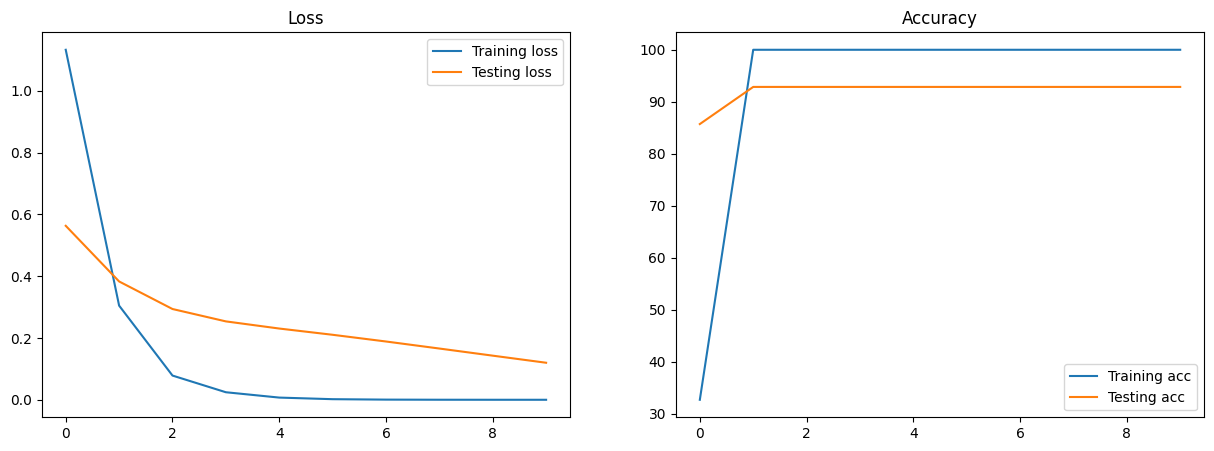

In [13]:
model = training_loop(model_utils.PageClassifier, X, y)

# 6. Save the model

In [14]:
torch.save(model.state_dict(), "./model_weight.pth")

# 7. Prediction

In [15]:
# def predict(model, input: list[int], label_mapping: dict[str]):
#     model.eval()

#     with torch.inference_mode():
#         X = torch.tensor([input]).type(torch.float32)
#         y_logits = model(X)
#         y_softmax = torch.softmax(y_logits, dim=1)
#         y_pred = y_softmax.argmax(dim=1)
        
#         result = y_softmax.detach().numpy()
#         class_prediction = label_mapping[y_pred.detach().numpy()[0]]

#         print("result", result)
#         print("class_prediction =>", class_prediction)

In [16]:
# TODO: Use real test data
input = preprocessing.pipeline_from_raw_text_to_vectors(
    data_dict["1"][-1], nlp, vocabulary
)
print(input)
model_utils.predict(model, input)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 5, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

TODO:
- Try auto-sklearn
- Try lazy predict
- Create model.py (with pytorch)